In [1]:
from nilearn.decomposition import CanICA
func_filenames = "/home/niusha/Documents/Codes/PD_test_merge_232_bootstrap.nii.gz"
canica = CanICA(n_components=20,
                memory="nilearn_cache", memory_level=2,
                verbose=10,
                mask_strategy='whole-brain-template',
                do_cca=False,
                random_state=0)
canica.fit(func_filenames)

[MultiNiftiMasker.fit] Loading data from [/home/niusha/Documents/Codes/PD_test_merge_232_bootstrap.nii.gz].
[{self.__class__.__name__}.fit] Computing mask


/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/joblib/memory.py:632: UserWarning: Cannot inspect object functools.partial(<function compute_multi_brain_mask at 0x7f828f6a5900>, mask_type='whole-brain'), ignore list will not work.
  return hashing.hash(filter_args(self.func, self.ignore, args, kwargs),


Template whole-brain mask computation


/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/joblib/memory.py:810: UserWarning: Cannot inspect object functools.partial(<function compute_multi_brain_mask at 0x7f828f6a5900>, mask_type='whole-brain'), ignore list will not work.
  argument_dict = filter_args(self.func, self.ignore,


[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data


________________________________________________________________________________
[Memory] Calling sklearn.utils.extmath.randomized_svd...
randomized_svd(array([[ 0.000537, ...,  0.002802],
       ...,
       [-0.000576, ..., -0.000579]], dtype=float32), n_components=20, transpose=True, random_state=0, n_iter=3)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


___________________________________________________randomized_svd - 0.8s, 0.0min


/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:322: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  S = est._fit_transform(X, compute_sources=compute_sources)


________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.00164 , ...,  0.000353],
       ...,
       [-0.001673, ..., -0.001881]]), whiten=True, fun='cube', random_state=209652396)


/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.4s remaining:    0.0s


_________________________________________________________fastica - 31.2s, 0.5min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.00164 , ...,  0.000353],
       ...,
       [-0.001673, ..., -0.001881]]), whiten=True, fun='cube', random_state=398764591)


/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:322: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  S = est._fit_transform(X, compute_sources=compute_sources)
/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


_________________________________________________________fastica - 35.0s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.00164 , ...,  0.000353],
       ...,
       [-0.001673, ..., -0.001881]]), whiten=True, fun='cube', random_state=924231285)


/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:322: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  S = est._fit_transform(X, compute_sources=compute_sources)
/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s


_________________________________________________________fastica - 34.9s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.00164 , ...,  0.000353],
       ...,
       [-0.001673, ..., -0.001881]]), whiten=True, fun='cube', random_state=1478610112)


/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:322: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  S = est._fit_transform(X, compute_sources=compute_sources)
/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.3min remaining:    0.0s


_________________________________________________________fastica - 34.2s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.00164 , ...,  0.000353],
       ...,
       [-0.001673, ..., -0.001881]]), whiten=True, fun='cube', random_state=441365315)


/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:322: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  S = est._fit_transform(X, compute_sources=compute_sources)
/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min remaining:    0.0s


_________________________________________________________fastica - 34.9s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.00164 , ...,  0.000353],
       ...,
       [-0.001673, ..., -0.001881]]), whiten=True, fun='cube', random_state=1537364731)


/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:322: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  S = est._fit_transform(X, compute_sources=compute_sources)
/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.4min remaining:    0.0s


_________________________________________________________fastica - 34.5s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.00164 , ...,  0.000353],
       ...,
       [-0.001673, ..., -0.001881]]), whiten=True, fun='cube', random_state=192771779)


/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:322: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  S = est._fit_transform(X, compute_sources=compute_sources)
/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.0min remaining:    0.0s


_________________________________________________________fastica - 35.1s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.00164 , ...,  0.000353],
       ...,
       [-0.001673, ..., -0.001881]]), whiten=True, fun='cube', random_state=1491434855)


/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:322: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  S = est._fit_transform(X, compute_sources=compute_sources)
/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  4.6min remaining:    0.0s


_________________________________________________________fastica - 34.3s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.00164 , ...,  0.000353],
       ...,
       [-0.001673, ..., -0.001881]]), whiten=True, fun='cube', random_state=1819583497)


/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:322: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  S = est._fit_transform(X, compute_sources=compute_sources)
/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  5.2min remaining:    0.0s


_________________________________________________________fastica - 34.6s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.00164 , ...,  0.000353],
       ...,
       [-0.001673, ..., -0.001881]]), whiten=True, fun='cube', random_state=530702035)


/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:322: FutureWarning: Starting in v1.3, whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  S = est._fit_transform(X, compute_sources=compute_sources)
/home/niusha/anaconda3/envs/py10/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.8min finished


_________________________________________________________fastica - 39.7s, 0.7min


CanICA(mask_strategy='whole-brain-template',
       memory=Memory(location=nilearn_cache/joblib), memory_level=2,
       random_state=0, verbose=10)

In [6]:
canica_components_img = canica.components_img_
# components_img is a Nifti Image object, and can be saved to a file with
# the following line:
canica_components_img.to_filename('ICAs.nii.gz')

/home/niusha/anaconda3/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),
/home/niusha/anaconda3/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/home/niusha/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


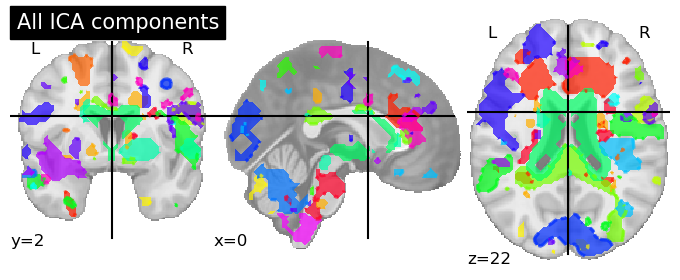

In [7]:
from nilearn.plotting import plot_prob_atlas

# Plot all ICA components together
plot_prob_atlas(canica_components_img, title='All ICA components')

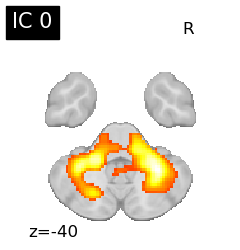

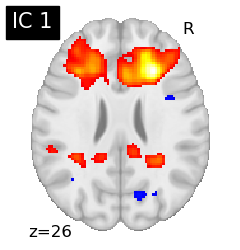

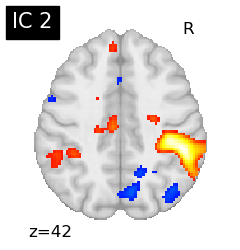

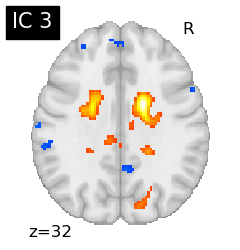

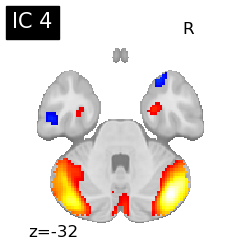

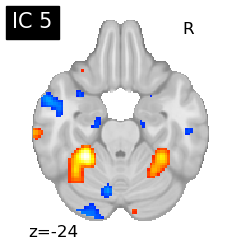

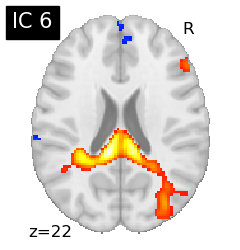

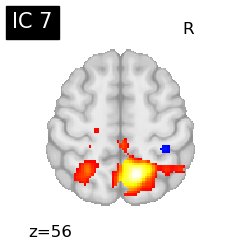

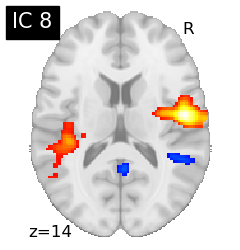

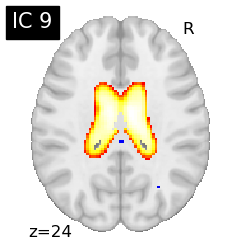

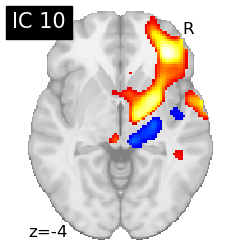

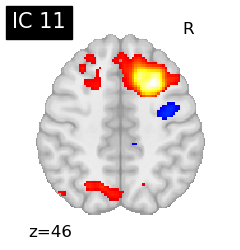

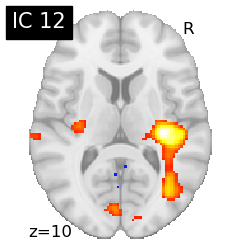

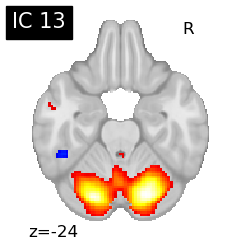

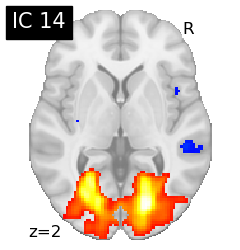

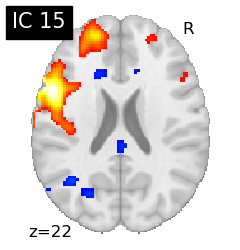

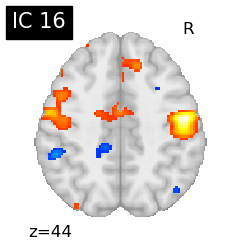

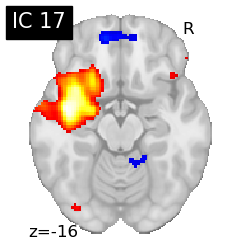

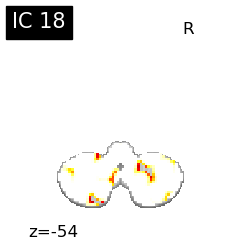

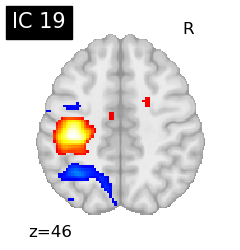

In [8]:
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(canica_components_img)):
    plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                  cut_coords=1, colorbar=False)